Loading and preprocessing data...
Data loading complete. Shape of X: (2543, 16384)
Splitting data into training/validation and test sets...
Data splitting complete.
Training initial pipeline on the train_val set...
Initial training complete.

--- Evaluating initial model on the test set ---


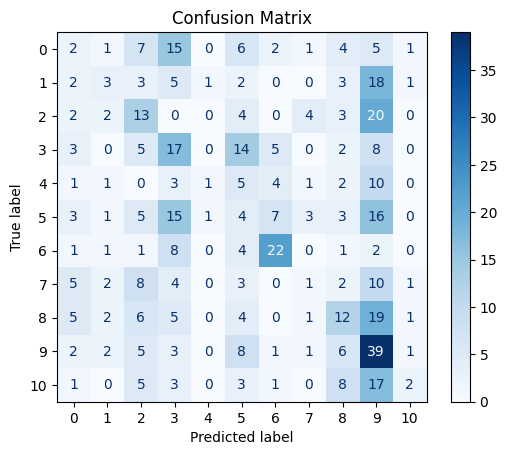

              precision    recall  f1-score   support

          Ac       0.07      0.05      0.06        44
          As       0.20      0.08      0.11        38
          Cb       0.22      0.27      0.25        48
          Cc       0.22      0.31      0.26        54
          Ci       0.33      0.04      0.06        28
          Cs       0.07      0.07      0.07        58
          Ct       0.52      0.55      0.54        40
          Cu       0.08      0.03      0.04        36
          Ns       0.26      0.22      0.24        55
          Sc       0.24      0.57      0.34        68
          St       0.29      0.05      0.09        40

    accuracy                           0.23       509
   macro avg       0.23      0.20      0.19       509
weighted avg       0.22      0.23      0.20       509


Training final pipeline on ALL data...
Final model training complete.
Final model saved to: model/et_pipeline__CloudPredictor_ncomp_150_AllData.pkl


In [10]:
# =============================================================================
# 1. Setup & Imports
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA


# =============================================================================
# 2. Helper Functions
# =============================================================================
def display_confusion_matrix(y_true, y_pred):
    """Displays a confusion matrix plot."""
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        # display_labels=CATEGORIES, # 'CATEGORIES' is defined globally later
        cmap=plt.cm.Blues
    )
    disp.ax_.set_title("Confusion Matrix")
    plt.show()


# =============================================================================
# 3. Data Loading and Preprocessing
# =============================================================================
print("Loading and preprocessing data...")

# Configuration
DATADIR = "CCSN_v2"
CATEGORIES = ['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']
IMG_SIZE = 128

# Load image data
training_data = []
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception as e:
            print(f"Could not load image {os.path.join(path, img)}: {e}")

# Shuffle and create feature/label arrays
import random
random.shuffle(training_data)

X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

# Reshape and convert to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE * IMG_SIZE)
y = np.array(y)

print(f"Data loading complete. Shape of X: {X.shape}")


# =============================================================================
# 4. Data Splitting
# =============================================================================
print("Splitting data into training/validation and test sets...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Data splitting complete.")


# =============================================================================
# 5. Initial Model Training & Evaluation
# (Train on 80% of data, evaluate on the 20% test set)
# =============================================================================
print("Training initial pipeline on the train_val set...")

# Define pipeline steps and create the pipeline
n_comp = 150  # Number of PCA components
pipeline_steps = [
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp)),
    ('et', ExtraTreesClassifier(n_estimators=100, random_state=21))
]
et_pipeline = Pipeline(steps=pipeline_steps)

# Train the pipeline
et_pipeline.fit(X_train_val, y_train_val)
print("Initial training complete.")

# Evaluate the pipeline on the test set
print("\n--- Evaluating initial model on the test set ---")
et_pred_test = et_pipeline.predict(X_test)

# Display results
display_confusion_matrix(y_test, et_pred_test)
print(classification_report(y_test, et_pred_test, target_names=CATEGORIES))


# =============================================================================
# 6. Final Model Training & Saving
# (Re-train the pipeline on ALL available data)
# =============================================================================
print("\nTraining final pipeline on ALL data...")

# Note: The original 'pipline_final_model' was created but not used for fitting.
# The 'et_pipeline' object is being re-fitted here on the full dataset (X, y),
# matching the logic from your original notebook.
et_pipeline.fit(X, y)

# Ensure the model directory exists
os.makedirs('model', exist_ok=True)

# Save the final, fully-trained pipeline
# Note: The original filename used undefined variables 'n'. Replaced with a static name.
final_model_path = f"model/et_pipeline__CloudPredictor_ncomp_{n_comp}_AllData.pkl"
joblib.dump(et_pipeline, final_model_path)

print("Final model training complete.")
print(f"Final model saved to: {final_model_path}")